In [1]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt


In [2]:
face_cascade=cv2.CascadeClassifier('./opencv/haarcascade_frontalface_default.xml')
eye_cascade=cv2.CascadeClassifier('./opencv/haarcascade_eye.xml')

In [3]:
def get_cropped_img(img_path):
    img=cv2.imread(img_path)
    if img is not None:
        gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        faces=face_cascade.detectMultiScale(gray,1.3,5)
        for (x,y,w,h) in faces:
            roi_gray=gray[y:y+h,x:x+w]
            roi_color=img[y:y+h,x:x+w]
            eyes=eye_cascade.detectMultiScale(roi_gray)
            if len(eyes)>=2:
                return roi_color
            else:
                continue

In [4]:
path_to_data="./dataset/"
path_to_cr_data="./dataset/cropped/"

In [5]:
import os
img_dirs=[]
import shutil
if os.path.exists(path_to_cr_data):
    shutil.rmtree(path_to_cr_data)
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [6]:
img_dirs

['./dataset/cristiano_ronaldo',
 './dataset/MSD',
 './dataset/roger_federer',
 './dataset/smrithi',
 './dataset/virat_kohli']

In [7]:
import shutil
if os.path.exists(path_to_cr_data):
    shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [8]:
c_img_dirs=[]
celebrity_file_names_dict={}
for img_dir in img_dirs:
    count=1
    celebrity_name=img_dir.split('/')[-1]
    print(celebrity_name)
    
    celebrity_file_names_dict[celebrity_name]=[]
    
    for entry in os.scandir(img_dir):
        roi_color=get_cropped_img(entry.path)
        if roi_color is not None:
            cropped_folder=path_to_cr_data+celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                c_img_dirs.append(cropped_folder)
                print("Generating",cropped_folder)
                
            cropped_file_name=celebrity_name+str(count)+'.png'
            cropped_file_path=cropped_folder+"/"+cropped_file_name
            
            cv2.imwrite(cropped_file_path,roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count+=1

cristiano_ronaldo
Generating ./dataset/cropped/cristiano_ronaldo
MSD
Generating ./dataset/cropped/MSD
roger_federer
Generating ./dataset/cropped/roger_federer
smrithi
Generating ./dataset/cropped/smrithi
virat_kohli
Generating ./dataset/cropped/virat_kohli


In [9]:
celebrity_file_names_dict = {}
for img_dir in c_img_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list


In [10]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'cristiano_ronaldo': 0,
 'MSD': 1,
 'roger_federer': 2,
 'smrithi': 3,
 'virat_kohli': 4}

In [11]:
import numpy as np
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

In [12]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])    

In [13]:
X = np.array(X).reshape(len(X),4096).astype(float)

In [14]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.7752808988764045

In [16]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.73      0.89      0.80        18
           1       0.53      0.53      0.53        15
           2       0.86      0.46      0.60        13
           3       0.86      0.86      0.86        22
           4       0.87      0.95      0.91        21

    accuracy                           0.78        89
   macro avg       0.77      0.74      0.74        89
weighted avg       0.78      0.78      0.77        89



In [17]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [18]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [19]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.798005,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.595383,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.840063,{'logisticregression__C': 10}


In [20]:
best_estimators['svm'].score(X_test,y_test)

0.8202247191011236

In [21]:
best_estimators['random_forest'].score(X_test,y_test)

0.6853932584269663

In [22]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.898876404494382

In [23]:
best_clf=best_estimators['logistic_regression']

In [24]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,best_clf.predict(X_test))
cm

array([[15,  0,  1,  1,  1],
       [ 0, 13,  1,  0,  1],
       [ 0,  1, 12,  0,  0],
       [ 0,  2,  0, 20,  0],
       [ 0,  0,  0,  1, 20]], dtype=int64)

Text(95.72222222222221, 0.5, 'Truth')

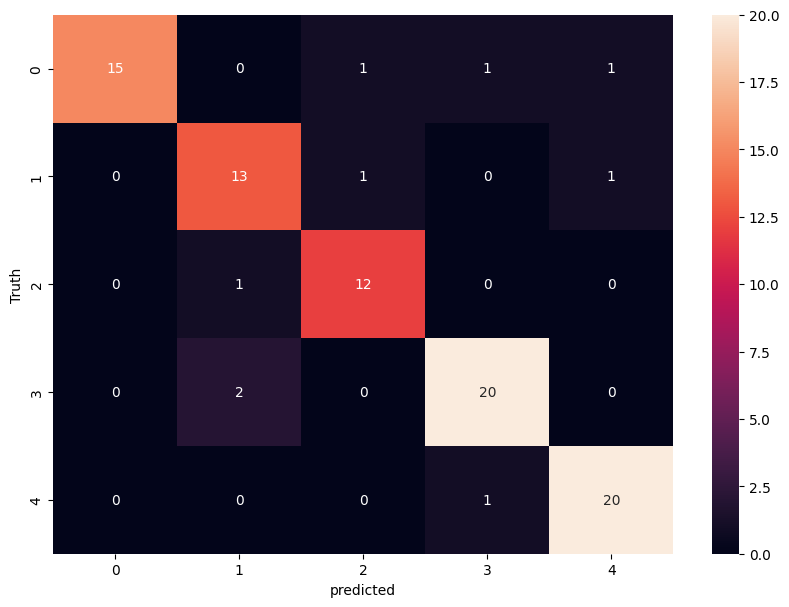

In [25]:
import seaborn as sn
plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True)
plt.xlabel('predicted')
plt.ylabel('Truth')

In [26]:
class_dict

{'cristiano_ronaldo': 0,
 'MSD': 1,
 'roger_federer': 2,
 'smrithi': 3,
 'virat_kohli': 4}

In [27]:
import joblib
joblib.dump(best_clf,'mod1.pkl')

['mod1.pkl']

In [28]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))